# Imports

In [75]:
!pip install --quiet rouge-score
!pip install --quiet seaborn
!pip install --quiet sentence_transformers

In [1]:
from sentence_transformers import SentenceTransformer
import torch
import nltk

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise
import numpy as np
from rouge_score import rouge_scorer

import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\meets\.conda\envs\resumeflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data

In [2]:
df_base = pd.read_csv("resume_gemma.csv", index_col=0)
df_base = df_base.drop(['ft_gemma2_Q8_0', 'ft_gemma2_Q4_K_M'], axis=1) # not using them in benchmark
df_base.head()

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\..."


In [3]:
def fix_null_remove_json(text):
    text = re.sub(r'\bNone\b', 'null', text)
    control_chars = r"[\x00-\x08\x0B\x0C\x0E-\x1F\x7F\t\r]" 
    text = re.sub(control_chars, '', text)
    pattern = r"```json\s*([\s\S]*?)```"
    # pattern = r"<output>\s*([\s\S]*?)<output>"
    match = re.search(pattern, text)
    
    if match:
        return match.group(1).strip()
    else:
        return text

def json_load(text):
    try:
        return json.loads(fix_null_remove_json(text))
    except Exception as e:
        print(e)
        print(text)
        return None

In [4]:
df_base['gemini_gen_loaded'] = df_base['gemini_gen'].apply(json_load)
df_base['base_gemma_loaded'] = df_base['base_gemma'].apply(json_load)
df_base.head()

Expecting value: line 91 column 3 (char 2312)
```json
{
  "name": null,
  "phone": null,
  "email": null,
  "linkedin": null,
  "github": null,
  "portfolio": null,
  "summary": "Advanced Desktop Support Lead/Manager with 14 plus years of experience in the Information Technology field providing Tier II - III technical support. I have demonstrated highly advanced troubleshooting techniques in resolving end-user issues with swift efficiency and going above and beyond SLA. 15 plus years of experience working with United Senate end-users across multiple technological platforms.",
  "skill_section": {
    "hard_skills": [
      "Back-up",
      "budgets",
      "hardware",
      "Database",
      "database management",
      "designing",
      "disaster recovery",
      "documentation",
      "financial",
      "Help Desk",
      "HP",
      "local area network",
      "LAN",
      "network",
      "networks",
      "NT servers",
      "PC's",
      "policies",
      "printer",
      "proce

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma,gemini_gen_loaded,base_gemma_loaded
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""...","{'name': 'Kevin L. Trostle', 'email': None, 'p...","{'name': 'Kevin L. Trostle', 'phone': None, 'e..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."


In [5]:
df_base = df_base.dropna(axis=0)
df_base = df_base.reset_index(drop=True)
df_base.shape

(109, 9)

In [6]:
df_base.head()

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma,gemini_gen_loaded,base_gemma_loaded
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""...","{'name': 'Kevin L. Trostle', 'email': None, 'p...","{'name': 'Kevin L. Trostle', 'phone': None, 'e..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."


In [7]:
df_demo = df_base[['ID', 'base_gemma_loaded']]
df_demo['base_gemma_loaded'][0].keys()

dict_keys(['name', 'phone', 'email', 'linkedin', 'github', 'portfolio', 'summary', 'skill_section', 'education', 'work_experience', 'projects', 'certifications', 'achievements'])

In [8]:
pd.json_normalize(df_demo['base_gemma_loaded'])

,name,phone,email,linkedin,github,portfolio,summary,education,work_experience,projects,certifications,achievements,skill_section.hard_skills,skill_section.soft_skills,certificates
0,None,None,None,None,None,None,Dedicated Information Assurance Professional w...,[{'school': 'Florence Darlington Technical Sch...,"[{'company_name': None, 'role': 'Information T...",[],[],[],"[Enterprise platforms, Product Lifecycle Manag...","[Self-directed, Decisive, Collaborative]",NaN
1,Kevin L. Trostle,None,None,None,None,None,None,"[{'school': 'Brockport High School', 'from_dat...","[{'company_name': None, 'role': 'Information T...",[],[{'name': 'Numerous certificates for web-based...,"[{'name': 'Superior Performer, 2nd Quarter 200...","[budget, cabling, cisco, hardware, LAN, materi...","[documentation, Electrician, feasibility studi...",NaN
2,None,None,None,None,None,None,Seeking a position as an Information Technolog...,"[{'school': 'U.S. Army', 'from_date': None, 't...","[{'company_name': 'Company Name', 'role': 'Inf...",[],"[{'name': 'Security', 'issuing_body': 'Comptia...","[{'award': 'Army Achievement Medal', 'achievem...","[Cisco, Windows 7, Network, Routing, LAN, WAN,...","[Communication, Counseling, Customer Assistanc...",NaN
3,None,None,None,None,None,None,Seventeen years experience in the information ...,"[{'school': 'Concordia University', 'from_date...",[{'company_name': 'Information Technology Inst...,[],[],[],"[Photoshop, Premier, Cable Wiring Standards, N...","[Team Building, Articulation and Development, ...",NaN
4,None,None,None,None,None,None,Innovative and solution focused web developmen...,"[{'school': 'Iowa State University', 'from_dat...","[{'company_name': None, 'role': 'Information T...",[],"[{'name': 'Microsoft Front Page Certified', 'a...",[Rolled out the first company wide intranet fo...,"[Project management, Program management, Proce...","[Results-oriented, Effective multi-tasker, Tea...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,None,None,None,None,None,None,Seasoned project manager driven to achieve res...,"[{'school': 'UNIVERSITY OF PHOENIX', 'from_dat...","[{'company_name': 'Company Name', 'role': 'Cor...",[],"[{'name': 'ITIL Foundation Course', 'year': 20...",[],"[SDLC Methodology, Software & Application Life...","[Strategic Planning & Visioning, Tactical Exec...",NaN
105,None,None,None,None,None,None,Analyst with extensive experience in Informati...,"[{'school': 'National American University', 'f...","[{'company_name': 'Company Name', 'role': 'IT ...",[],"[{'name': 'Comptia Network', 'date': 'February...",[],"[TCP/IP, Network monitoring and tools, storage...","[client management, project management, commun...",NaN
106,None,None,None,None,None,None,None,[{'school': 'University of Maryland University...,"[{'company_name': 'IT Manager', 'role': 'IT Ma...",[],[],[],"[Antivirus, Backup Exec, Backup, budget, Cisco...","[customer satisfaction, leadership, direction,...",NaN
107,None,None,None,None,None,None,None,"[{'school': 'Oneonta State University', 'from_...","[{'company_name': None, 'role': 'Subject Matte...",[],"[{'name': 'Certification in Network Security',...",[],"[SAP, HP ALM, Network Configuration, Database ...","[Teamwork, Communication, Problem-solving, Tim...",NaN


# Rogue Score:
- to measure content preservation

In [9]:
df_base['base_gemma_loaded'][0].keys()

dict_keys(['name', 'phone', 'email', 'linkedin', 'github', 'portfolio', 'summary', 'skill_section', 'education', 'work_experience', 'projects', 'certifications', 'achievements'])

In [10]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

skill_scores = []
work_exp_scores = []

for i in range(df_base.shape[0]):
    resume_txt = df_base['Resume_str'][i]
    gemma_skills_section = str(df_base['base_gemma_loaded'][i]['skill_section'])
    gemma_work_experience = str(df_base['base_gemma_loaded'][i]['work_experience'])
    skill_scores.append(scorer.score(resume_txt, gemma_skills_section))
    work_exp_scores.append(scorer.score(resume_txt, gemma_work_experience))

Rouge 1 scores:
{'skills': 0.9385292261597064, 'work_exp': 0.9032446714783833}
Rouge 2 scores:
{'skills': 0.7297256134847167, 'work_exp': 0.8267174153925515}
Rouge L scores:
{'skills': 0.7579687666763465, 'work_exp': 0.8590986539815698}


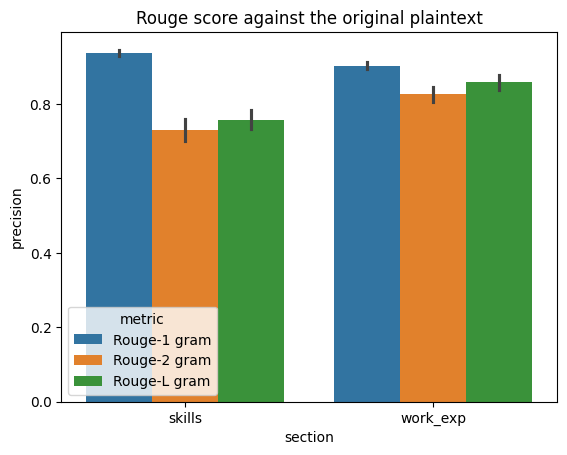

In [12]:
skills_df = pd.DataFrame(skill_scores)
work_exp_df = pd.DataFrame(work_exp_scores)

r1_scores = {
    'skills' : skills_df['rouge1'].str[0],
    'work_exp' : work_exp_df['rouge1'].str[0],
}

r2_scores = {
    'skills' : skills_df['rouge2'].str[0],
    'work_exp' : work_exp_df['rouge2'].str[0],
}

rL_scores = {
    'skills' : skills_df['rougeL'].str[0],
    'work_exp' : work_exp_df['rougeL'].str[0],
}

r1_scores_avg = {
    'skills' : sum([s['rouge1'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rouge1'].precision for s in work_exp_scores])/len(work_exp_scores),
}

r2_scores_avg = {
    'skills' : sum([s['rouge2'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rouge2'].precision for s in work_exp_scores])/len(work_exp_scores),
}

rL_scores_avg = {
    'skills' : sum([s['rougeL'].precision for s in skill_scores])/len(skill_scores),
    'work_exp' : sum([s['rougeL'].precision for s in work_exp_scores])/len(work_exp_scores),
}

print("Rouge 1 scores:")
print(r1_scores_avg)

print("Rouge 2 scores:")
print(r2_scores_avg)

print("Rouge L scores:")
print(rL_scores_avg)

r1_df = pd.DataFrame(r1_scores)
r1_df['metric'] = 'Rouge-1 gram'
r2_df = pd.DataFrame(r2_scores)
r2_df['metric'] = 'Rouge-2 gram'
rL_df = pd.DataFrame(rL_scores)
rL_df['metric'] = 'Rouge-L gram'

score_df = pd.concat([r1_df, r2_df, rL_df])
score_df = score_df.melt(id_vars=['metric'], var_name='section', value_name='precision')
sns.barplot(score_df, x='section', y='precision', hue='metric')
plt.title("Rouge score against the original plaintext")
plt.show()

# Cosine Similarity

In [84]:
df_base.head()

,ID,Resume_str,Resume_html,Category,Resume_json,gemini_gen,base_gemma,gemini_gen_loaded,base_gemma_loaded
0,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY', 'summary': ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
1,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY SPECIALIST GS...,"{\n ""name"": ""Kevin L. Trostle"",\n ""email"": n...","```json\n{\n ""name"": ""Kevin L. Trostle"",\n ""...","{'name': 'Kevin L. Trostle', 'email': None, 'p...","{'name': 'Kevin L. Trostle', 'phone': None, 'e..."
2,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY SUPERVISOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
3,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,"{'name': 'INFORMATION TECHNOLOGY INSTRUCTOR', ...","{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."
4,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,{'name': 'INFORMATION TECHNOLOGY MANAGER/ANALY...,"{\n ""name"": null,\n ""email"": null,\n ""phone...","```json\n{\n ""name"": null,\n ""phone"": null,\...","{'name': None, 'email': None, 'phone': None, '...","{'name': None, 'phone': None, 'email': None, '..."


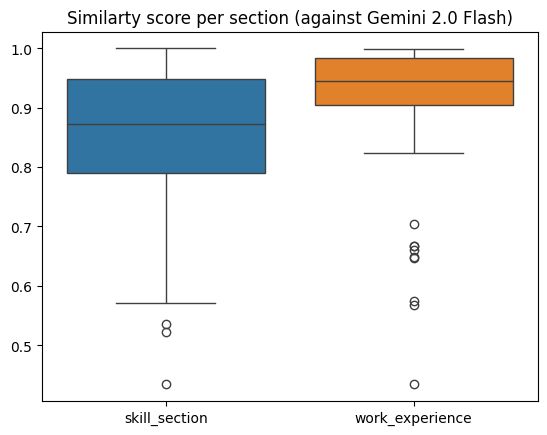

In [ ]:
# embedder = SentenceTransformer("sentence-transformers/bert-large-nli-cls-token")
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2") # max words length of 256

def chunk_and_embed_avg(text, chunk_size=256):

    nltk.download('punkt', quiet=True)  # Ensure punkt is downloaded

    tokens = nltk.word_tokenize(text)
    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunks.append(" ".join(tokens[i:i + chunk_size]))

    embeddings = embedder.encode(chunks)
    avg_embeddings = embeddings.mean(axis=0)

    return avg_embeddings

similarity_scores = {}
skills_str_gemma = []
work_exp_str_gemma = []
skills_str_gemini= []
work_exp_str_gemini = []
for i in range(df_base.shape[0]):
    skills_str_gemma.append(str(df_base['base_gemma_loaded'][i]['skill_section']['hard_skills'] + df_base['base_gemma_loaded'][i]['skill_section']['soft_skills']))
    work_exp_str_gemma.append(str(df_base['base_gemma_loaded'][i]['work_experience']))
    
    skills_str_gemini.append(str(df_base['gemini_gen_loaded'][i]['skill_section']))
    work_exp_str_gemini.append(str(df_base['gemini_gen_loaded'][i]['work_experience']))
    
skills_emb_gemma = list(map(chunk_and_embed_avg, skills_str_gemma))
work_exp_emb_gemma = list(map(chunk_and_embed_avg, work_exp_str_gemma))
skills_emb_gemini = list(map(chunk_and_embed_avg, skills_str_gemini))
work_exp_emb_gemini = list(map(chunk_and_embed_avg, work_exp_str_gemini))

similarity_scores["skill_section"] = torch.diagonal(embedder.similarity(skills_emb_gemma, skills_emb_gemini), 0)
similarity_scores["work_experience"] = torch.diagonal(embedder.similarity(work_exp_emb_gemma, work_exp_emb_gemini), 0)

sns.boxplot(similarity_scores)
plt.title("Similarty score per section (against Gemini 2.0 Flash)")
plt.show()

In [187]:
outlier_skill_id = similarity_scores['skill_section'] < 0.65
outlier_work_exp_id = similarity_scores['work_experience'] < 0.75
print("Skill section", sum(similarity_scores['skill_section'] < 0.65))
print("Work experience:", sum(similarity_scores['work_experience'] < 0.75))


Skill section tensor(5)
Work experience: tensor(9)


In [176]:
# import ast
outliers_skill_gemma = [skills_str_gemma[i] for i in range(len(skills_str_gemma)) if outlier_skill_id[i]]
outliers_skill_gemini = [skills_str_gemini[i] for i in range(len(skills_str_gemini)) if outlier_skill_id[i]]
outliers_skill_scores = [similarity_scores['skill_section'][i] for i in range(len(skills_str_gemini)) if outlier_skill_id[i]]

i = 1
for outlier_gemma, outlier_gemini, outlier_skill_score in zip(outliers_skill_gemma, outliers_skill_gemini, outliers_skill_scores):
    print("Index", i)
    print("Score:", outlier_skill_score)
    print("Gemma skills:", r"{}".format(outlier_gemma))
    print("Gemini skills:", outlier_gemini)
    i += 1
# gemma_skill = ast.literal_eval(outliers_skill_gemma[0])
# gemini_skill = ast.literal_eval(outliers_skill_gemini[0])

Index 1
Score: tensor(0.5366)
Gemma skills: ['Python', 'Visual Basic', 'C#', 'A+', 'Cisco Certification', 'Web Design', 'Game Design', 'Help Desk', 'Java', 'Javascript', 'Microsoft Suite', 'Google Suite', 'Project Management', 'Data Analysis', 'Network Fundamentals', 'Windows O.S. Fundamentals', 'Software Development', 'Web Development', 'Teamwork', 'Communication', 'Training', 'Problem-solving', 'Leadership']
Gemini skills: ['Google and Microsoft suite experience through coursework and classroom implementation.', 'Familiar with both the educational and information technology fields.', 'Experience in both project management and educating teachers on the use of technology in the classroom.']
Index 2
Score: tensor(0.6045)
Gemma skills: ['Desktops', 'Ethernet cables', 'Cisco routers', 'Video & Sound Cards', 'CD-ROM Drives', 'Multiplexors', 'Scanners', 'Monitors', 'Switches', 'TCP/IP Configuration', 'Installing, adding and deleting user accounts with Active Directory']
Gemini skills: Deskt

In [201]:
outliers_work_exp_gemma = [work_exp_str_gemma[i] for i in range(len(work_exp_str_gemma)) if outlier_work_exp_id[i]]
outliers_work_exp_gemini = [work_exp_str_gemini[i] for i in range(len(work_exp_str_gemini)) if outlier_work_exp_id[i]]
outliers_work_exp_score = [similarity_scores['work_experience'][i] for i in range(len(work_exp_str_gemma)) if outlier_work_exp_id[i]]
i = 0
for outlier_gemma, outlier_gemini, outlier_score in zip(outliers_work_exp_gemma, outliers_work_exp_gemini, outliers_work_exp_score):
    print("Index", i)
    print("score:", outlier_score)
    print("Gemma skills:", outlier_gemma)
    print("Gemini", outlier_gemini)
    i += 1

Index 0
score: tensor(0.6664)
Gemma skills: [{'company_name': None, 'role': 'Information Technology Intern', 'from_date': '06/2012', 'to_date': '08/2012', 'location': None, 'description': 'Participated in human and technology interaction management with supervisor.\nDeveloped an interface between website and databases via Excel that allowed House of Representatives and Senators more effective and easier access to information.\nCompleted several workshops and lectures about the history of the Library of Congress.'}, {'company_name': None, 'role': 'Media Student Assistant', 'from_date': '02/2012', 'to_date': '08/2012', 'location': None, 'description': 'Set up and maintained the Computer Aided Real-Time translation (CART) system in classrooms and various locations around campus, when needed.\nAssisted staff, faculty and students on a daily basis with equipment repairs, customer service and technology problems.\nVerified that each classroom had the appropriate equipment and technology need

In [204]:
import ast
gemma_we = ast.literal_eval(outliers_work_exp_gemma[5])
gemini_we = ast.literal_eval(outliers_work_exp_gemini[5])
print(gemma_we)

[{'company_name': 'KnowledgeSoft, Inc.', 'role': None, 'from_date': '3/1997', 'to_date': None, 'location': 'Mechanicsburg, PA', 'description': 'Courses in Intranetware 4.11 Administration and 4.1a Advanced Administration'}, {'company_name': None, 'role': 'Production Associate', 'from_date': '03/2006', 'to_date': 'Current', 'location': None, 'description': None}, {'company_name': None, 'role': 'Information Technology Technician', 'from_date': '01/2000', 'to_date': '10/2002', 'location': None, 'description': 'Provided computer help desk support via telephone communications with end-users. Performed diagnostics and troubleshooting of system issues, documented help desk tickets/resolutions, and maintained equipment inventory lists.'}, {'company_name': None, 'role': 'Information Technology Technician', 'from_date': '02/1996', 'to_date': '01/2000', 'location': None, 'description': 'Provided computer help desk support and technical training on hardware/software to end users. Documented help d

In [205]:
import json
import difflib

def compare_json_side_by_side(json_str1, json_str2):
    """
    Compares two JSON strings or dictionaries side by side, highlighting differences.

    Args:
        json_str1 (str or dict): The first JSON string or dictionary.
        json_str2 (str or dict): The second JSON string or dictionary.
    """

    try:
        # Load JSON strings or dictionaries into Python dictionaries
        if isinstance(json_str1, str):
            dict1 = json.loads(json_str1)
        else:
            dict1 = json_str1

        if isinstance(json_str2, str):
            dict2 = json.loads(json_str2)
        else:
            dict2 = json_str2

        # Convert dictionaries to pretty-printed JSON strings for comparison
        str1 = json.dumps(dict1, indent=4, sort_keys=True)
        str2 = json.dumps(dict2, indent=4, sort_keys=True)

        # Use difflib to compare the strings
        diff = difflib.unified_diff(str1.splitlines(keepends=True), str2.splitlines(keepends=True), fromfile='json1', tofile='json2')
        # print(diff)

        # Print the side-by-side comparison with differences highlighted
        for line in diff:
            if line.startswith('---') or line.startswith('+++') or line.startswith('@@'):
                print(line, end='')
            elif line.startswith('+'):
                print('\033[92m' + line + '\033[0m', end='')  # Green for additions
            elif line.startswith('-'):
                print('\033[91m' + line + '\033[0m', end='')  # Red for removals
            else:
                print(line, end='')

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

compare_json_side_by_side(gemma_we, gemini_we)

--- json1
+++ json2
@@ -1,33 +1,25 @@
 [
     {
-        "company_name": "KnowledgeSoft, Inc.",
-        "description": "Courses in Intranetware 4.11 Administration and 4.1a Advanced Administration",
-        "from_date": "3/1997",
-        "location": "Mechanicsburg, PA",
-        "role": null,
-        "to_date": null
-    },
-    {
-        "company_name": null,
-        "description": null,
+        "description": "cover letter typically accompanies each resume you send out. Your cover letter may make the difference between obtaining a job interview or having your resume ignored, so it makes good sense to devote the necessary time and effort to writing effective cover letters. A cover letter should complement, not duplicate, your resume. Its purpose is to interpret the data-oriented, factual resume and add a personal touch. A cover letter is often your earliest written contact with a potential employer, creating a critical first impression. Find out more of the differences between 